code can be dirrectly run via
https://www.kaggle.com/code/chtalhaanwar/audio-classification

In [1]:
!pip install pytorch_lightning -q
!pip install timm -q

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from glob import glob
import os

In [3]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import DataLoader, Dataset
import torchaudio.transforms as T
from torchvision.transforms import Compose
from torchvision import transforms as T
from torchaudio import transforms as TA
import torchaudio
import torch.nn as nn
import torch
import timm
from sklearn.metrics import classification_report

In [4]:
aug=T.Compose([
           
                         
            TA.AmplitudeToDB(),
            TA.TimeMasking(time_mask_param=10) ,
            TA.FrequencyMasking(freq_mask_param=10) ,
            TA.Fade(),
               
            T.Resize((224,224))
            ])


In [5]:
from torch.utils.data import DataLoader, Dataset
class DataReader(Dataset):
    def __init__(self, dataset_path, transform=None):
        self.paths=glob(os.path.join(dataset_path,'*/*.wav'))
        self.labels=[i.split('/')[-2] for i in self.paths]#get folder name
        self.di={j:i for i,j in enumerate(set(self.labels))}#convert folders to integers
        self.labels=list(map(self.di.get, self.labels, self.labels))
        #https://stackoverflow.com/a/17295920/11170350 #replace list folders by int
        self.transform = transform

    def __getitem__(self, index):
        x=self.paths[index]
        y=self.labels[index]
        waveform, sample_rate = torchaudio.load(x)
        waveforms=torch.tensor_split(waveform,5,dim=1)
        idx=torch.randperm(len(waveforms))[0]
        waveform=waveforms[idx]
        spectrogram = TA.Spectrogram(normalized=True)(waveform)
     
        out=aug(spectrogram)
        return out, y
    
    def __len__(self):
        return len(self.labels)

    

In [6]:
datareader=DataReader('../input/urdu-emotion-dataset/')

In [7]:
train_set, val_set = torch.utils.data.random_split(datareader, [int(len(datareader)*0.8),int(len(datareader)*0.2)])
dl=DataLoader(train_set, batch_size = 4, shuffle=True)
test=next(iter(dl))
test[0].shape,test[1]

(torch.Size([4, 1, 224, 224]), tensor([3, 2, 0, 3]))

In [8]:
dl=DataLoader(val_set, batch_size = 4, shuffle=True)
test=next(iter(dl))
test[0].shape,test[1]

(torch.Size([4, 1, 224, 224]), tensor([0, 1, 1, 3]))

In [9]:
import torchvision.models as models
from pytorch_lightning import seed_everything, LightningModule, Trainer
import torchmetrics
import timm
class OurModel(LightningModule):
    def __init__(self):
        super(OurModel,self).__init__()
        #architecute
        self.model=timm.create_model('resnet50',pretrained=True)
        self.model.conv1=nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc=nn.Linear(in_features=2048, out_features=1000)
        self.fc1=nn.Linear(in_features=1000, out_features=500)
        self.fc2=nn.Linear(in_features=500, out_features=len(datareader.di))
        self.relu=nn.ReLU()
        #parameters
        self.lr=1e-3
        self.batch_size=12
        self.numworker=2
        self.acc = torchmetrics.Accuracy()
        self.criterion=nn.CrossEntropyLoss()
        
        self.trainacc,self.valacc=[],[]
        self.trainloss,self.valloss=[],[]
        self.test_pred=0
        
    def forward(self,x):
        x= self.model(x)
        x=self.relu(x)
        x= self.fc1(x)
        x=self.relu(x)
        x=self.fc2(x)
        return x

    def configure_optimizers(self):
        opt=torch.optim.AdamW(params=self.parameters(),lr=self.lr )
        return opt
        
 
    def train_dataloader(self):
        return DataLoader(train_set, batch_size = self.batch_size, 
                          num_workers=self.numworker,pin_memory=True,shuffle=True)

    def training_step(self,batch,batch_idx):
        image,label=batch
        out = self(image)
        loss=self.criterion(out,label)
        acc=self.acc(out,label)
        return {'loss':loss,'acc':acc}

    def training_epoch_end(self, outputs):
        #average loss and accuracy in all batches of train data
        loss=torch.stack([x["loss"] for x in outputs]).mean().detach().cpu().numpy().round(2)
        acc=torch.stack([x["acc"] for x in outputs]).mean().detach().cpu().numpy().round(2)
        self.trainacc.append(acc)
        self.trainloss.append(loss)

    
        
    def val_dataloader(self):
        ds=DataLoader(val_set, batch_size = self.batch_size,
                      num_workers=self.numworker,pin_memory=True,shuffle=False)
        return ds

    def validation_step(self,batch,batch_idx):
        image,label=batch
        out=self(image)
        loss=self.criterion(out,label)
        acc=self.acc(out,label)
        self.log('val_acc', acc, on_epoch=True,prog_bar=True)
        return {'loss':loss,'acc':acc}

    def validation_epoch_end(self, outputs):
        loss=torch.stack([x["loss"] for x in outputs]).mean().detach().cpu().numpy().round(2)
        acc=torch.stack([x["acc"] for x in outputs]).mean().detach().cpu().numpy().round(2)
        self.valacc.append(acc)
        self.valloss.append(loss)
        print('validation loss accuracy ',self.current_epoch,loss, acc)
    
    def test_dataloader(self):
        ds=DataLoader(val_set, batch_size = self.batch_size,
                      num_workers=self.numworker,pin_memory=True,shuffle=False)
        return ds
    
    def test_step(self,batch,batch_idx):
        image,label=batch
        pred = self(image)
        
        return {'label':label,'pred':pred}

    def test_epoch_end(self, outputs):

        label=torch.cat([x["label"] for x in outputs])
        pred=torch.cat([x["pred"] for x in outputs])
        pred=torch.argmax(pred,1)
        acc=self.acc(pred.flatten(),label)
        pred=pred.detach().cpu().numpy().ravel()
        label=label.detach().cpu().numpy().ravel()

        print(classification_report(label,pred,target_names=list(datareader.di.keys())))


In [10]:
model=OurModel()


In [11]:
seed_everything(0)
trainer = Trainer(max_epochs=50, 
                deterministic=True,
                gpus=-1,precision=16,
                accumulate_grad_batches=1,
                enable_progress_bar = True,
                num_sanity_val_steps=0,
                #limit_train_batches=20,
                #limit_val_batches=5
                )

In [12]:
trainer.fit(model)

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1937: PossibleUserWarning: The number of training batches (27) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

validation loss accuracy  0 1.42 0.3


Validation: 0it [00:00, ?it/s]

validation loss accuracy  1 2.84 0.23


Validation: 0it [00:00, ?it/s]

validation loss accuracy  2 0.99 0.47


Validation: 0it [00:00, ?it/s]

validation loss accuracy  3 2.13 0.33


Validation: 0it [00:00, ?it/s]

validation loss accuracy  4 1.34 0.51


Validation: 0it [00:00, ?it/s]

validation loss accuracy  5 1.18 0.61


Validation: 0it [00:00, ?it/s]

validation loss accuracy  6 0.55 0.84


Validation: 0it [00:00, ?it/s]

validation loss accuracy  7 0.66 0.76


Validation: 0it [00:00, ?it/s]

validation loss accuracy  8 0.42 0.88


Validation: 0it [00:00, ?it/s]

validation loss accuracy  9 0.42 0.86


Validation: 0it [00:00, ?it/s]

validation loss accuracy  10 0.35 0.89


Validation: 0it [00:00, ?it/s]

validation loss accuracy  11 0.2 0.91


Validation: 0it [00:00, ?it/s]

validation loss accuracy  12 0.4 0.83


Validation: 0it [00:00, ?it/s]

validation loss accuracy  13 0.42 0.85


Validation: 0it [00:00, ?it/s]

validation loss accuracy  14 0.22 0.95


Validation: 0it [00:00, ?it/s]

validation loss accuracy  15 0.26 0.88


Validation: 0it [00:00, ?it/s]

validation loss accuracy  16 0.27 0.9


Validation: 0it [00:00, ?it/s]

validation loss accuracy  17 0.6 0.79


Validation: 0it [00:00, ?it/s]

validation loss accuracy  18 0.58 0.77


Validation: 0it [00:00, ?it/s]

validation loss accuracy  19 0.56 0.82


Validation: 0it [00:00, ?it/s]

validation loss accuracy  20 0.15 0.94


Validation: 0it [00:00, ?it/s]

validation loss accuracy  21 0.63 0.74


Validation: 0it [00:00, ?it/s]

validation loss accuracy  22 0.32 0.92


Validation: 0it [00:00, ?it/s]

validation loss accuracy  23 0.57 0.89


Validation: 0it [00:00, ?it/s]

validation loss accuracy  24 0.23 0.92


Validation: 0it [00:00, ?it/s]

validation loss accuracy  25 0.16 0.95


Validation: 0it [00:00, ?it/s]

validation loss accuracy  26 0.87 0.71


Validation: 0it [00:00, ?it/s]

validation loss accuracy  27 0.67 0.82


Validation: 0it [00:00, ?it/s]

validation loss accuracy  28 0.82 0.8


Validation: 0it [00:00, ?it/s]

validation loss accuracy  29 0.2 0.95


Validation: 0it [00:00, ?it/s]

validation loss accuracy  30 0.24 0.94


Validation: 0it [00:00, ?it/s]

validation loss accuracy  31 0.45 0.79


Validation: 0it [00:00, ?it/s]

validation loss accuracy  32 0.35 0.92


Validation: 0it [00:00, ?it/s]

validation loss accuracy  33 0.34 0.94


Validation: 0it [00:00, ?it/s]

validation loss accuracy  34 0.19 0.96


Validation: 0it [00:00, ?it/s]

validation loss accuracy  35 0.31 0.87


Validation: 0it [00:00, ?it/s]

validation loss accuracy  36 0.28 0.9


Validation: 0it [00:00, ?it/s]

validation loss accuracy  37 0.41 0.85


Validation: 0it [00:00, ?it/s]

validation loss accuracy  38 0.2 0.92


Validation: 0it [00:00, ?it/s]

validation loss accuracy  39 0.18 0.96


Validation: 0it [00:00, ?it/s]

validation loss accuracy  40 0.2 0.98


Validation: 0it [00:00, ?it/s]

validation loss accuracy  41 0.61 0.83


Validation: 0it [00:00, ?it/s]

validation loss accuracy  42 0.28 0.92


Validation: 0it [00:00, ?it/s]

validation loss accuracy  43 0.11 0.98


Validation: 0it [00:00, ?it/s]

validation loss accuracy  44 0.2 0.94


Validation: 0it [00:00, ?it/s]

validation loss accuracy  45 0.1 0.96


Validation: 0it [00:00, ?it/s]

validation loss accuracy  46 0.32 0.88


Validation: 0it [00:00, ?it/s]

validation loss accuracy  47 0.2 0.95


Validation: 0it [00:00, ?it/s]

validation loss accuracy  48 0.14 0.95


Validation: 0it [00:00, ?it/s]

validation loss accuracy  49 0.37 0.9


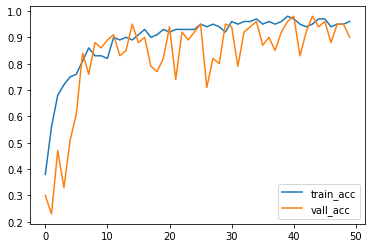

In [13]:
plt.plot(model.trainacc,label='train_acc')
plt.plot(model.valacc,label='vall_acc')
plt.legend()

In [14]:
trainer.validate(model)

Validation: 0it [00:00, ?it/s]

validation loss accuracy  50 0.23 0.93


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │     0.925000011920929     │
└───────────────────────────┴───────────────────────────┘

[{'val_acc': 0.925000011920929}]

In [15]:
trainer.test(model)

Testing: 0it [00:00, ?it/s]

              precision    recall  f1-score   support

     Neutral       0.94      0.94      0.94        17
       Happy       0.96      0.93      0.94        27
         Sad       1.00      0.95      0.97        19
       Angry       0.89      1.00      0.94        17

    accuracy                           0.95        80
   macro avg       0.95      0.95      0.95        80
weighted avg       0.95      0.95      0.95        80



[{}]